# Comparing 3 Gradient Boosting Methods 
- XGBoost, LightGBM, CatBoost
<br><br>
과목 : 경제학도를 위한 머신러닝
<br>팀원(7조) : 최준혁, 이승주


## Data Loading : Flight csv
- https://www.kaggle.com/datasets/usdot/flight-delays?datasetId=810&sortBy=voteCount&select=flights.csv
- 비행기 지연 여부를 예측하는 데이터 셋
<br><br>
- "MONTH" : Month of the Flight Trip
- "DAY" : Day of the Flight Trip
- "DAY_OF_WEEK" : 
- "AIRLINE" : Airline Identifier
- "FLIGHT_NUMBER" : Flight Identifier
- "DESTINATION_AIRPORT" : Destination Airport
- "ORIGIN_AIRPORT" : Starting Airport
- "AIR_TIME" : The time duration between wheels_off and wheels_on time
- "DEPARTURE_TIME" : WHEEL_OFF - TAXI_OUT
- "DISTANCE" : Distance between two airports
- "ARRIVAL_DELAY" : 1(ARRIVAL_TIME - SCHEDULED_ARRIVAL)

In [ ]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import time
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#colab에 google drive mount

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Random sampling Number
seed = 1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd, numpy as np, time
from sklearn.model_selection import train_test_split

origin = pd.read_csv("/content/drive/MyDrive/flights.csv")

origin = origin[["MONTH","DAY","DAY_OF_WEEK","AIRLINE","FLIGHT_NUMBER","DESTINATION_AIRPORT","ORIGIN_AIRPORT","AIR_TIME", "DEPARTURE_TIME","DISTANCE","ARRIVAL_DELAY"]]
origin.dropna(inplace=True)

origin["ARRIVAL_DELAY"] = (origin["ARRIVAL_DELAY"]>10)*1

cols = ["AIRLINE","FLIGHT_NUMBER","DESTINATION_AIRPORT","ORIGIN_AIRPORT"]
for item in cols:
    origin[item] = origin[item].astype("category").cat.codes +1

data = origin.sample(frac = 0.001, random_state=seed)
data2 = origin.sample(frac = 0.01, random_state=seed)

In [ ]:
origin #EDA는 나중에?

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,DESTINATION_AIRPORT,ORIGIN_AIRPORT,AIR_TIME,DEPARTURE_TIME,DISTANCE,ARRIVAL_DELAY
0,1,1,4,2,97,815,606,169.0,2354.0,1448.0,0
1,1,1,4,1,2333,773,765,263.0,2.0,2330.0,0
2,1,1,4,12,838,604,867,266.0,18.0,2296.0,0
3,1,1,4,1,257,741,765,258.0,15.0,2342.0,0
4,1,1,4,2,134,555,866,199.0,24.0,1448.0,0
...,...,...,...,...,...,...,...,...,...,...,...
4856718,10,30,5,3,327,101,183,137.0,1759.0,937.0,0
4856719,10,30,5,11,377,217,143,116.0,1754.0,925.0,0
4856720,10,30,5,11,1645,277,143,168.0,1756.0,1346.0,0
4856721,10,30,5,4,1248,277,20,252.0,1754.0,1919.0,0


In [ ]:
origin.isnull().sum() #결측치가 없는 데이터

MONTH                  0
DAY                    0
DAY_OF_WEEK            0
AIRLINE                0
FLIGHT_NUMBER          0
DESTINATION_AIRPORT    0
ORIGIN_AIRPORT         0
AIR_TIME               0
DEPARTURE_TIME         0
DISTANCE               0
ARRIVAL_DELAY          0
dtype: int64

In [ ]:
data #원본 데이터를 1/10로 줄인 sample

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,DESTINATION_AIRPORT,ORIGIN_AIRPORT,AIR_TIME,DEPARTURE_TIME,DISTANCE,ARRIVAL_DELAY
2602948,6,14,7,14,2522,558,858,118.0,527.0,874.0,0
4078086,9,11,5,11,998,623,675,120.0,905.0,641.0,1
4382930,9,30,3,14,402,733,814,64.0,1839.0,423.0,0
4008491,9,6,7,14,3323,733,738,82.0,1725.0,577.0,0
2281007,5,25,1,3,310,766,628,133.0,1435.0,867.0,0
...,...,...,...,...,...,...,...,...,...,...,...
4366286,9,29,2,1,2198,766,611,129.0,1804.0,978.0,0
873137,2,27,5,8,3117,766,657,34.0,832.0,135.0,0
467998,1,31,6,12,1905,766,655,101.0,1755.0,599.0,0
2240555,5,22,5,6,603,741,609,97.0,1621.0,594.0,1


## EDA
- 전체에서 랜텀 추출한 5만개 데이터로 진행함

In [ ]:
cat_list = origin.iloc[:,:7].columns
num_list = origin.iloc[:,7:-1].columns
print(cat_list) #AIRLINE
print(num_list)

Index(['MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'DESTINATION_AIRPORT', 'ORIGIN_AIRPORT'],
      dtype='object')
Index(['AIR_TIME', 'DEPARTURE_TIME', 'DISTANCE'], dtype='object')


Categorical Variable

In [ ]:
import plotly.express as px
data2
ax1 = px.pie(data2["DESTINATION_AIRPORT"],names="DESTINATION_AIRPORT",title="DESTINATION_AIRPORT",template = 'seaborn')
ax1.update_traces(textposition="inside", textinfo="value+percent+label")

ax2 = px.pie(data2["ORIGIN_AIRPORT"],names="ORIGIN_AIRPORT",title="ORIGIN_AIRPORT",template = 'seaborn')
ax2.update_traces(textposition="inside", textinfo="value+percent+label")

ax3 = px.pie(data2["AIRLINE"],names="AIRLINE",title="AIRLINE",template = 'seaborn')
ax3.update_traces(textposition="inside", textinfo="value+percent+label")


display(ax2)
display(ax1)
display(ax3)

In [ ]:
len(data2['FLIGHT_NUMBER'].unique()) # 항공편 number의 수 6001

6040

In [ ]:
data2['FLIGHT_NUMBER'] #6001개의 항공편이 총 47671번

2602948    2522
4078086     998
4382930     402
4008491    3323
2281007     310
           ... 
1975784     549
1204301    5065
2188058    1420
4198498    3669
4054216     296
Name: FLIGHT_NUMBER, Length: 47671, dtype: int16

Numerical Variable

Text(0.5, 1.0, 'DISTANCE')

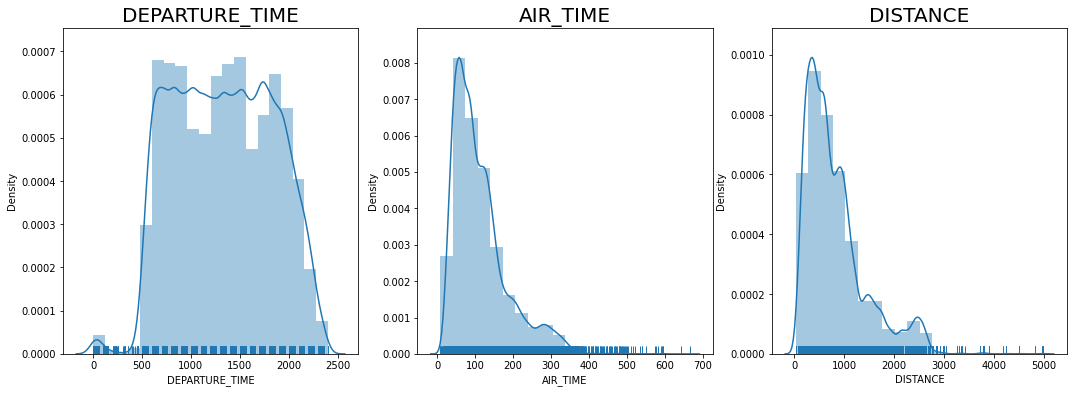

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt 
# plt.figure(figsize=(12, 8))
f, ax = plt.subplots(1, 3, figsize=(18, 6))

sns.distplot(data2['DEPARTURE_TIME'], bins = 20, hist= True, kde = True, rug = True, ax= ax[0])
ax[0].set_title("DEPARTURE_TIME",fontsize = 20)
sns.distplot(data2['AIR_TIME'], bins = 20, hist= True, kde = True, rug = True, ax= ax[1])
ax[1].set_title("AIR_TIME",fontsize = 20)
sns.distplot(data2['DISTANCE'], bins = 20, hist= True, kde = True, rug = True, ax= ax[2])
ax[2].set_title("DISTANCE",fontsize = 20)

오른쪽 2개의 분포를 log변환으로 정규화 시켜줄 필요가 있음
- 효과는 굉장했다

Text(0.5, 1.0, 'DISTANCE')

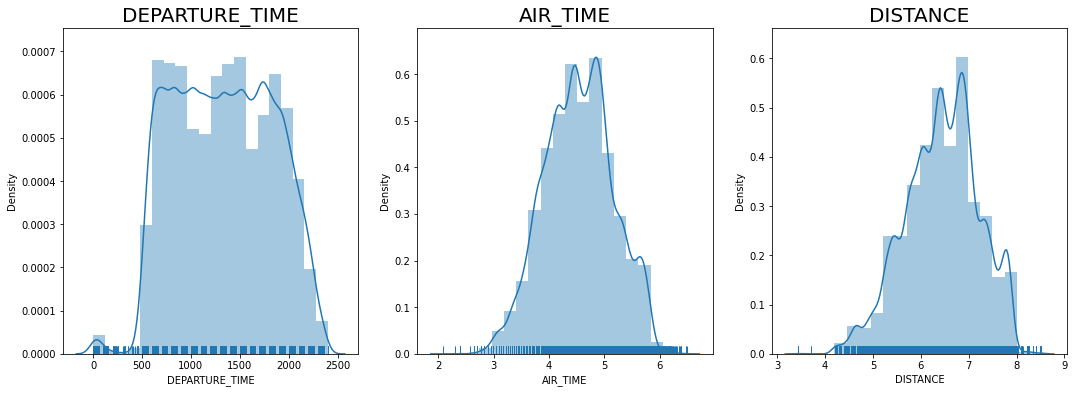

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt 
# plt.figure(figsize=(12, 8))
f, ax = plt.subplots(1, 3, figsize=(18, 6))

sns.distplot((data2['DEPARTURE_TIME']), bins = 20, hist= True, kde = True, rug = True, ax= ax[0])
ax[0].set_title("DEPARTURE_TIME",fontsize = 20)
sns.distplot(np.log(data2['AIR_TIME']), bins = 20, hist= True, kde = True, rug = True, ax= ax[1])
ax[1].set_title("AIR_TIME",fontsize = 20)
sns.distplot(np.log(data2['DISTANCE']), bins = 20, hist= True, kde = True, rug = True, ax= ax[2])
ax[2].set_title("DISTANCE",fontsize = 20)

Text(0.5, 1.0, 'ARRIVAL_DELAY dist : unbalance target')

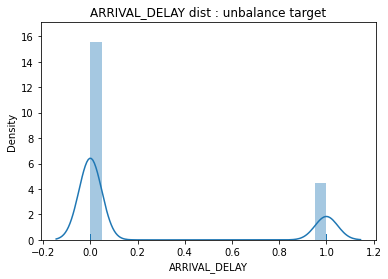

In [ ]:
sns.distplot(data2['ARRIVAL_DELAY'], bins = 20, hist= True, kde = True, rug = True) #target값의 분포가 unbalance함
plt.title("ARRIVAL_DELAY dist : unbalance target")

In [ ]:
#수치형 변수 로그변환으로 정규화시킴
origin['AIR_TIME'] = np.log(origin['AIR_TIME'])
origin['DISTANCE'] = np.log(origin['DISTANCE'])

In [ ]:
data = origin.sample(frac = 0.001, random_state=seed)
data2 = origin.sample(frac = 0.01, random_state=seed)

수치형 자료들을 범주화하기

In [ ]:
for i in num_list:
  print(f"---{i}---")
  display(data2[i].describe())
  print()

---AIR_TIME---


count    47671.000000
mean         4.540113
std          0.618605
min          2.079442
25%          4.094345
50%          4.543295
75%          4.962845
max          6.501290
Name: AIR_TIME, dtype: float64


---DEPARTURE_TIME---


count    47671.00000
mean      1337.57750
std        494.62691
min          1.00000
25%        923.00000
50%       1334.00000
75%       1740.00000
max       2400.00000
Name: DEPARTURE_TIME, dtype: float64


---DISTANCE---


count    47671.000000
mean         6.442597
std          0.760707
min          3.433987
25%          5.921578
50%          6.470800
75%          6.956545
max          8.513787
Name: DISTANCE, dtype: float64

In [ ]:
data2['AIR_TIME_cat'] = np.digitize(data2['AIR_TIME'], np.linspace(2.0,6.5,10))
data2['DEPARTURE_TIME_cat'] = np.digitize(data2['DEPARTURE_TIME'], np.linspace(0.9,2400.1,10))
data2['DISTANCE_cat'] = np.digitize(data2['DISTANCE'], np.linspace(3.4,8.6,10))

In [ ]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47671 entries, 2602948 to 4054216
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   MONTH                47671 non-null  int64  
 1   DAY                  47671 non-null  int64  
 2   DAY_OF_WEEK          47671 non-null  int64  
 3   AIRLINE              47671 non-null  int8   
 4   FLIGHT_NUMBER        47671 non-null  int16  
 5   DESTINATION_AIRPORT  47671 non-null  int16  
 6   ORIGIN_AIRPORT       47671 non-null  int16  
 7   AIR_TIME             47671 non-null  float64
 8   DEPARTURE_TIME       47671 non-null  float64
 9   DISTANCE             47671 non-null  float64
 10  ARRIVAL_DELAY        47671 non-null  int64  
 11  AIR_TIME_cat         47671 non-null  int64  
 12  DEPARTURE_TIME_cat   47671 non-null  int64  
 13  DISTANCE_cat         47671 non-null  int64  
dtypes: float64(3), int16(3), int64(7), int8(1)
memory usage: 4.3 MB


Text(0.5, 1.0, 'DISTANCE_cat')

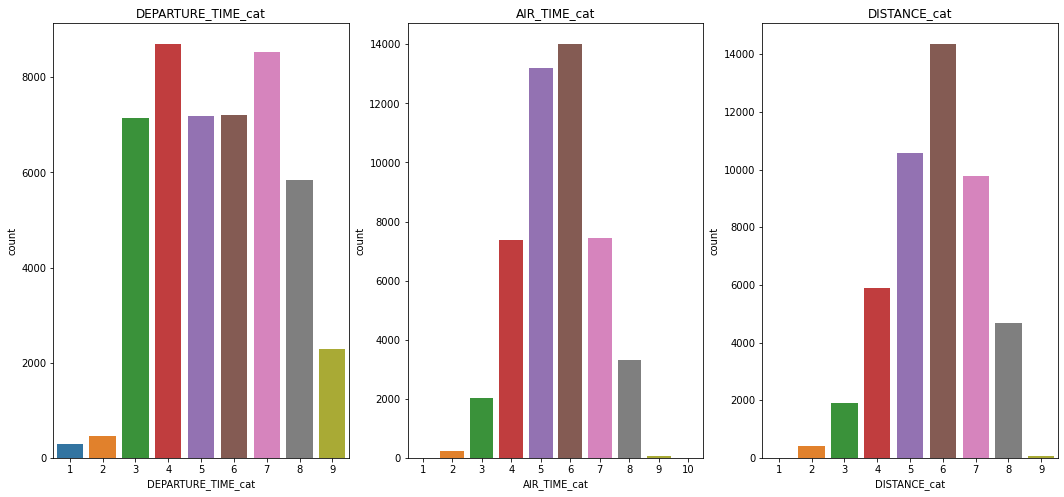

In [ ]:
f, ax = plt.subplots(1, 3, figsize=(18, 8))

sns.countplot('DEPARTURE_TIME_cat', data = data2, ax=ax[0])
sns.countplot('AIR_TIME_cat', data = data2, ax=ax[1])
sns.countplot('DISTANCE_cat', data = data2, ax=ax[2])
ax[0].set_title("DEPARTURE_TIME_cat")
ax[1].set_title("AIR_TIME_cat")
ax[2].set_title("DISTANCE_cat")

In [ ]:
data3 = data2.copy()
data2 = data2[origin.columns]

## (Reference) Regarding optimization
- 아래 구현된 부분 = bayesian optimazation methods : 하지만 본 프로젝트에서는 시도만 하였고 사용하지 않음
- (hyperopt)모듈을 사용하여 객체지향으로 구현함
- hyperparameter를 잘 튜닝해야 모형간 성능을 비교할 수 있지만 각 모형별로 최적의 튜닝을 하기 쉽지 않았음. 여러 가지 방법 중 하나로 bayesian optimization을 시도해보았으나 결국 사용하지 않았지만 소개함
<br><br>
- 따라서 본 프로젝트에서는 초기값으로 부여한 값들 중 default보다 성능이 좋은 파라미터 근처의 값들로 grid search하였음.
- 하지만 사용한 방법이 좋은 방법이라 생각하지 않으며 본 프로젝트의 한계점이라고 생각함

In [ ]:
from hyperopt import hp
import numpy as np
from sklearn.metrics import mean_squared_error


# XGB parameters
xgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.05)),
    'max_depth':        hp.choice('max_depth',        np.arange(10, 50, 3, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'n_estimators':     100,
}
xgb_fit_params = {
    'eval_metric': 'rmse',
    'early_stopping_rounds': 10,
    'verbose': False
}
xgb_para = dict()
xgb_para['reg_params'] = xgb_reg_params
xgb_para['fit_params'] = xgb_fit_params
xgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))


# LightGBM parameters
lgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.05)),
    'max_depth':        hp.choice('max_depth',       np.arange(10, 50, 3, dtype=int)), 
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'n_estimators':     100,
}
lgb_fit_params = {
    'eval_metric': 'l2',
    'early_stopping_rounds': 10,
    'verbose': False
}
lgb_para = dict()
lgb_para['reg_params'] = lgb_reg_params
lgb_para['fit_params'] = lgb_fit_params
lgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))


# CatBoost parameters
ctb_reg_params = {
    'learning_rate':     hp.choice('learning_rate',     np.arange(0.05, 0.31, 0.05)),
    'max_depth':         hp.choice('max_depth',         np.arange(10, 50, 3, dtype=int)),
    'colsample_bylevel': hp.choice('colsample_bylevel', np.arange(0.3, 0.8, 0.1)),
    'n_estimators':      100,
    'eval_metric':       'RMSE',
}
ctb_fit_params = {
    'early_stopping_rounds': 10,
    'verbose': False
}
ctb_para = dict()
ctb_para['reg_params'] = ctb_reg_params
ctb_para['fit_params'] = ctb_fit_params
ctb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

In [ ]:
import lightgbm as lgb
import xgboost as xgb
import catboost as ctb
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials


class HPOpt(object):

    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test  = x_test
        self.y_train = y_train
        self.y_test  = y_test

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials

    def xgb_reg(self, para):
        reg = xgb.XGBRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def lgb_reg(self, para):
        reg = lgb.LGBMRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def ctb_reg(self, para):
        reg = ctb.CatBoostRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def train_reg(self, reg, para):
        reg.fit(self.x_train, self.y_train,
                eval_set=[(self.x_train, self.y_train), (self.x_test, self.y_test)],
                **para['fit_params'])
        pred = reg.predict(self.x_test)
        loss = para['loss_func'](self.y_test, pred)
        return {'loss': loss, 'status': STATUS_OK}

In [ ]:
'''obj = HPOpt(train, test, y_train, y_test)

xgb_opt = obj.process(fn_name='xgb_reg', space=xgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)
lgb_opt = obj.process(fn_name='lgb_reg', space=lgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)
ctb_opt = obj.process(fn_name='ctb_reg', space=ctb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)'''

"obj = HPOpt(train, test, y_train, y_test)\n\nxgb_opt = obj.process(fn_name='xgb_reg', space=xgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)\nlgb_opt = obj.process(fn_name='lgb_reg', space=lgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)\nctb_opt = obj.process(fn_name='ctb_reg', space=ctb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)"

## Enhanced Gradient Boosting Methods

|  | XGBoost  | lightGBM  | CatBoost |
| --- | --- | --- | --- |
| sparse matrix | 잘 처리하는 편임 | 잘 처리하는 편임 | 잘 처리하는 못함 |
| 오버피팅 취약도 | 셋중에서는 가장 취약 | 대표본에서 강하지만 <br>소표본에서 취약                     (대략 10000개 이하) | 강함 |
| 범주형 변수 처리 | No | Yes (not best) | Yes (best) |
| 학습 속도 | 가장 느림 | 매우 빠름 (best) | 매우 빠름 (not best) |
| 예측 속도 | 가장 느림 | 매우 빠름 (not best) | 매우 빠름 (best) |
| 하이퍼파라미터 튜닝 민감도 | 하이퍼파라미터에 따라 성능이 크게 좌우 | 하이퍼파라미터에 따라 성능이 크게 좌우 | 하이퍼파라미터를 설정하지 않아도 스스로 최적화하는 경향이 있음. |
| 특징 | 기존GBM보다 속도나 성능면에서<br> 우월하지만 새로나온 모형보다 밀림 | 속도가 가장 빠르고 가볍지만 <br> 소표본에서 오버피팅에 취약함 | LightGBM에 비해 조금 느리지만 오버피팅에 강하고 <br> 범주형 변수 처리와 순서자료(시계열)등 처리에 강함 <br> 하지만 전부 수치형자료일 경우 느리고 <br> 성능에서 큰 효과를 내기 어려운 알고리즘임 |

### XGBoost

In [ ]:
import xgboost as xgb
from sklearn import metrics
def XGBOOST(train, test, y_train, y_test):
  return_D = dict()
  def auc(m, train, test): 
      return (metrics.roc_auc_score(y_train,m.predict_proba(train)[:,1]),
                              metrics.roc_auc_score(y_test,m.predict_proba(test)[:,1]))

  # Parameter Tuning
  model = xgb.XGBClassifier()
  param_dist = {
                "max_depth": [3,7,11],
                "min_child_weight" : [1,2,3],
                "n_estimators": [300],
                "learning_rate": [0.09 ,0.1, 0.11]
                }

  start = time.time()
  grid_search = GridSearchCV(model, param_grid=param_dist, cv = 3, 
                                    verbose=False, n_jobs=-1,scoring="roc_auc")
  grid_search.fit(train, y_train)
  end = time.time()
  xgb_gs_time = end - start
  # print(f"xgb_gs_time = {xgb_gs_time:.8f} sec")

  params = grid_search.best_params_
  print(params)

  start = time.time()
  model = xgb.XGBClassifier(\
                            max_depth=params['max_depth'], \
                            min_child_weight=params['min_child_weight'],\
                            n_estimators=params['n_estimators'], \
                            learning_rate=params['learning_rate'], \
                            n_jobs=-1 , verbose=False)
  model.fit(train,y_train)
  end = time.time()
  xgb_train_time = end - start
  # print(f"xgb_train_time = {xgb_train_time:.8f} sec")

  start = time.time()
  xgb_result = auc(model, train, test)
  end = time.time()
  xgb_pred_time = end - start
  # print(f"xgb_pred_time = {xgb_pred_time:.8f} sec")

  model0 = xgb.XGBClassifier()
  model0.fit(train,y_train)
  default_result = auc(model0, train, test)

  return_D['xgb_gs_time'] = xgb_gs_time
  return_D['xgb_train_time'] = xgb_train_time
  return_D['xgb_pred_time'] = xgb_pred_time
  return_D['xgb_result'] = xgb_result
  return_D['default_result'] = default_result

  return return_D

### LightGBM

In [ ]:
import lightgbm as lgb
from sklearn import metrics
def LIGHTGBM(train, test, y_train, y_test,all_cat = False):
  return_D = dict()
  def auc2(m, train, test): 
      return (metrics.roc_auc_score(y_train,m.predict(train)),
                              metrics.roc_auc_score(y_test,m.predict(test)))

  lg = lgb.LGBMClassifier(silent=True)
  param_dist = {
                "max_depth": [15,20,25],
                "learning_rate" : [0.01,0.05,0.1],
                "num_leaves": [15, 20, 25],
                "n_estimators": [300]
              }

  start = time.time()
  grid_search = GridSearchCV(lg, n_jobs=-1, param_grid=param_dist, cv = 3, scoring="roc_auc", verbose=False)
  grid_search.fit(train,y_train)
  params = grid_search.best_params_
  print(params)
  end = time.time()
  lgb_gs_time = end - start
  # print(f"lgb_gs_time = {lgb_gs_time:.8f} sec")

  d_train = lgb.Dataset(train, label=y_train, free_raw_data=False)

  # Without Categorical Features
  start = time.time()
  model2 = lgb.train(params, d_train,verbose_eval=False)
  end = time.time()
  lgb_without_cat_train_time = end - start
  # print(f"lgb_without_cat_train_time = {lgb_without_cat_train_time:.8f} sec")

  # auc2(model2, train, test)
  start = time.time()
  lgb_without_cat_result = auc2(model2, train, test)
  end = time.time()
  lgb_without_cat_pred_time = end - start
  # print(f"lgb_without_cat_pred_time = {lgb_without_cat_pred_time:.8f} sec")

  #With Catgeorical Features
  start = time.time()
  cate_features_name = ["MONTH","DAY","DAY_OF_WEEK","AIRLINE","DESTINATION_AIRPORT",'FLIGHT_NUMBER',
                  "ORIGIN_AIRPORT"]
  if all_cat == True: 
    cate_features_name = train.columns.tolist()
    print(cate_features_name)
  model2 = lgb.train(params, d_train, categorical_feature = cate_features_name,verbose_eval=False)
  end = time.time()
  lgb_with_cat_train_time = end - start
  # print(f"lgb_with_cat_train_time = {lgb_with_cat_train_time:.8f} sec")

  # auc2(model2, train, test)
  start = time.time()
  lgb_with_cat_result = auc2(model2, train, test)
  end = time.time()
  lgb_with_cat_pred_time = end - start
  # print(f"lgb_with_cat_pred_time = {lgb_with_cat_pred_time:.8f} sec")

  return_D['lgb_gs_time'] = lgb_gs_time
  return_D['lgb_without_cat_train_time'] = lgb_without_cat_train_time
  return_D['lgb_without_cat_pred_time'] = lgb_without_cat_pred_time
  return_D['lgb_without_cat_result'] = lgb_without_cat_result
  return_D['lgb_with_cat_train_time'] = lgb_with_cat_train_time
  return_D['lgb_with_cat_pred_time'] = lgb_with_cat_pred_time
  return_D['lgb_with_cat_result'] = lgb_with_cat_result

  model0 = lgb.train(params = [], train_set = d_train, categorical_feature = cate_features_name,verbose_eval=False)
  default_result = auc2(model0, train, test)
  return_D['default_result'] = default_result

  return return_D

### CatBoost

In [ ]:
import catboost as cb
from catboost import CatBoostClassifier
def CATBOOST(train, test, y_train, y_test,all_cat = False):
  return_D = dict()
  cat_features_index = [0,1,2,3,4,5,6]

  def auc(m, train, test): 
      return (metrics.roc_auc_score(y_train,m.predict_proba(train)[:,1]),
                              metrics.roc_auc_score(y_test,m.predict_proba(test)[:,1]))

  params = {'depth': [2, 4, 6],
            'learning_rate' : [0.05,0.1,0.15],
          'l2_leaf_reg': [1,4,9],
          'iterations': [700]}
  cb = CatBoostClassifier(verbose = False)

  start = time.time()
  grid_search = GridSearchCV(cb, params, scoring="roc_auc", cv = 3)
  grid_search.fit(train, y_train)
  end = time.time()
  cb_gs_time = end - start
  # print(f"cb_gs_time = {cb_gs_time:.8f} sec")

  params = grid_search.best_params_
  print(params)

  # Without Categorical features
  start = time.time()
  clf = CatBoostClassifier(eval_metric="AUC", depth=params['depth'], iterations= params['iterations'], verbose = False, \
                          l2_leaf_reg= params['l2_leaf_reg'], learning_rate= params['learning_rate'])
  clf.fit(train,y_train)
  end = time.time()
  cb_without_cat_train_time = end - start
  # print(f"cb_without_cat_train_time = {cb_without_cat_train_time:.8f} sec")

  start = time.time()
  cb_without_cat_result = auc(clf, train, test)
  end = time.time()
  cb_without_cat_pred_time = end - start
  # print(f"cb_without_cat_pred_time = {cb_without_cat_pred_time:.8f} sec")

  # With Categorical features
  if all_cat == True: 
    cat_features_index = [0,1,2,3,4,5,6,7,8,9]

  cat_names = train.iloc[:,:7].columns.tolist()
  train[cat_names] = train[cat_names].astype(str)
  test[cat_names] = test[cat_names].astype(str)

  start = time.time()
  clf = CatBoostClassifier(eval_metric="AUC", depth=params['depth'],verbose = False, \
                          iterations= params['iterations'], l2_leaf_reg= params['l2_leaf_reg'], learning_rate= params['learning_rate'])

  clf.fit(train,y_train, cat_features= cat_features_index)
  end = time.time()
  cb_with_cat_train_time = end - start
  # print(f"cb_with_cat_train_time = {cb_with_cat_train_time:.8f} sec")

  start = time.time()
  cb_with_cat_result = auc(clf, train, test)
  end = time.time()
  cb_with_cat_pred_time = end - start
  # print(f"cb_with_cat_pred_time = {cb_with_cat_pred_time:.8f} sec")

  return_D['cb_gs_time'] = cb_gs_time
  return_D['cb_without_cat_train_time'] = cb_without_cat_train_time
  return_D['cb_without_cat_pred_time'] = cb_without_cat_pred_time
  return_D['cb_without_cat_result'] = cb_without_cat_result
  return_D['cb_with_cat_train_time'] = cb_with_cat_train_time
  return_D['cb_with_cat_pred_time'] = cb_with_cat_pred_time
  return_D['cb_with_cat_result'] = cb_with_cat_result

  model0 = CatBoostClassifier(verbose = False)
  model0.fit(train,y_train,cat_features= cat_features_index)
  default_result = auc(model0, train, test)
  return_D['default_result'] = default_result

  return return_D

## TEST1 : sample number = 5000
- 목적 : LightGBM이 10000개 이하의 표본에서 오버피팅에 약한 특징을 확인해보기 위함.

In [ ]:
#원자료에서 추출된 약 5000개의 데이터를 train, split하여 MinMaxScale
train, test, y_train, y_test = train_test_split(data.drop(["ARRIVAL_DELAY"], axis=1), data["ARRIVAL_DELAY"],    
                                                random_state=10, test_size=0.25)
#Scaling : x_train
features = train.columns.values
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(train)
train = pd.DataFrame(scaler.transform(train))
train.columns = features

#Scaling : y_train
features = test.columns.values
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(test)
test = pd.DataFrame(scaler.transform(test))
test.columns = features

In [ ]:
#XGBoost
result_xgb = XGBOOST(train, test, y_train, y_test)
result_xgb

{'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 300}


{'xgb_gs_time': 69.48226118087769,
 'xgb_train_time': 1.4406678676605225,
 'xgb_pred_time': 0.057296037673950195,
 'xgb_result': (0.9030913102249329, 0.6812447434819175),
 'default_result': (0.8071186137906396, 0.6919928893646303)}

In [ ]:
#LightGBM
result_lgb = LIGHTGBM(train, test, y_train, y_test)
result_lgb

{'learning_rate': 0.01, 'max_depth': 15, 'n_estimators': 300, 'num_leaves': 20}


{'lgb_gs_time': 21.029716968536377,
 'lgb_without_cat_train_time': 0.3362236022949219,
 'lgb_without_cat_pred_time': 0.09801101684570312,
 'lgb_without_cat_result': (0.8499809394371333, 0.6717983026225246),
 'lgb_with_cat_train_time': 0.20595407485961914,
 'lgb_with_cat_pred_time': 0.0942070484161377,
 'lgb_with_cat_result': (0.8055318449519895, 0.6535591406070801),
 'default_result': (0.9161919941952759, 0.6525001911461121)}

In [ ]:
#CatBoost
result_cb = CATBOOST(train, test, y_train, y_test)
result_cb

{'depth': 2, 'iterations': 700, 'l2_leaf_reg': 1, 'learning_rate': 0.1}


{'cb_gs_time': 116.7373399734497,
 'cb_without_cat_train_time': 0.9503176212310791,
 'cb_without_cat_pred_time': 0.011542081832885742,
 'cb_without_cat_result': (0.8437917813062839, 0.6837602263169968),
 'cb_with_cat_train_time': 3.0611627101898193,
 'cb_with_cat_pred_time': 0.02339959144592285,
 'cb_with_cat_result': (0.7852574373027187, 0.6876099090144506),
 'default_result': (0.8371749115111067, 0.6711139995412493)}

In [ ]:
temp_row = list(result_xgb['xgb_result']).copy()
temp_row.append(result_xgb['xgb_train_time']) ; temp_row.append(result_xgb['xgb_pred_time']) ; temp_row.append(result_xgb['xgb_gs_time'])
row1 = pd.DataFrame(temp_row, index = ["Train_AUC","Test_AUC","Train_time","Prediction_time","HyperParams_Tuning_time"]).T

temp_row = list(result_lgb['lgb_without_cat_result']).copy()
temp_row.append(result_lgb['lgb_without_cat_train_time']) ; temp_row.append(result_lgb['lgb_without_cat_pred_time']) ; temp_row.append(result_lgb['lgb_gs_time'])
row2 = pd.DataFrame(temp_row, index = ["Train_AUC","Test_AUC","Train_time","Prediction_time","HyperParams_Tuning_time"]).T

temp_row = list(result_lgb['lgb_with_cat_result']).copy()
temp_row.append(result_lgb['lgb_with_cat_train_time']) ; temp_row.append(result_lgb['lgb_with_cat_pred_time']) ; temp_row.append(result_lgb['lgb_gs_time'])
row3 = pd.DataFrame(temp_row, index = ["Train_AUC","Test_AUC","Train_time","Prediction_time","HyperParams_Tuning_time"]).T

temp_row = list(result_cb['cb_without_cat_result']).copy()
temp_row.append(result_cb['cb_without_cat_train_time']) ; temp_row.append(result_cb['cb_without_cat_pred_time']) ; temp_row.append(result_cb['cb_gs_time'])
row4 = pd.DataFrame(temp_row, index = ["Train_AUC","Test_AUC","Train_time","Prediction_time","HyperParams_Tuning_time"]).T

temp_row = list(result_cb['cb_with_cat_result']).copy()
temp_row.append(result_cb['cb_with_cat_train_time']) ; temp_row.append(result_cb['cb_with_cat_pred_time']); temp_row.append(result_cb['cb_gs_time'])
row5 = pd.DataFrame(temp_row, index = ["Train_AUC","Test_AUC","Train_time","Prediction_time","HyperParams_Tuning_time"]).T

rows = [row2,row3,row4,row5]

for r in rows:
  row1 = pd.concat([row1, r],axis = 0)
table1 = row1.copy()
table1.index = [["XGboost", "LightGBM", "LightGBM", "CatBoost","CatBoost"], ["-", "without_cat","with_cat", "without_cat","with_cat"]]
table1['train_test_diff'] = table1['Train_AUC'] - table1['Test_AUC']
table1

Train_AUC  Test_AUC  Train_time  Prediction_time  \
XGboost  -             0.903091  0.681245    1.440668         0.057296   
LightGBM without_cat   0.849981  0.671798    0.336224         0.098011   
         with_cat      0.805532  0.653559    0.205954         0.094207   
CatBoost without_cat   0.843792  0.683760    0.950318         0.011542   
         with_cat      0.785257  0.687610    3.061163         0.023400   

                      HyperParams_Tuning_time  train_test_diff  
XGboost  -                          69.482261         0.221847  
LightGBM without_cat                21.029717         0.178183  
         with_cat                   21.029717         0.151973  
CatBoost without_cat               116.737340         0.160032  
         with_cat                  116.737340         0.097648

< 관찰 포인트 > : 현재 소표본인 상태
- LightGBM은 Train 속도가 가장 빠르다
- Catboost는 예측속도가 가장 빠르다
- 대부분 성능이 소표본에서 좋지 않다(LightGBM, Catboost는 학습률이 낮은 모습을 보이고, XGboost는 오버피팅의 경향이 보임
- 파라미터 튜닝 타임은 예상대로 XGB, CAT, LGB순으로 오래걸림. 소표본에서 LGB는 확실히 빠르지만 나머지 둘은 큰 차이까진 나지 않는다 

## TEST2 : sample number = 50000
- 목적 : LightGBM이 50000개의 표본에서 오버피팅에 대해 어떻게 변하는 지 확인하기 위함

In [ ]:
origin

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,DESTINATION_AIRPORT,ORIGIN_AIRPORT,AIR_TIME,DEPARTURE_TIME,DISTANCE,ARRIVAL_DELAY
0,1,1,4,2,97,815,606,5.129899,2354.0,7.277939,0
1,1,1,4,1,2333,773,765,5.572154,2.0,7.753624,0
2,1,1,4,12,838,604,867,5.583496,18.0,7.738924,0
3,1,1,4,1,257,741,765,5.552960,15.0,7.758761,0
4,1,1,4,2,134,555,866,5.293305,24.0,7.277939,0
...,...,...,...,...,...,...,...,...,...,...,...
4856718,10,30,5,3,327,101,183,4.919981,1759.0,6.842683,0
4856719,10,30,5,11,377,217,143,4.753590,1754.0,6.829794,0
4856720,10,30,5,11,1645,277,143,5.123964,1756.0,7.204893,0
4856721,10,30,5,4,1248,277,20,5.529429,1754.0,7.559559,0


In [ ]:
#원자료에서 추출된 약 50000개의 데이터를 train, split하여 MinMaxScale
train, test, y_train, y_test = train_test_split(data2.drop(["ARRIVAL_DELAY"], axis=1), data2["ARRIVAL_DELAY"],    
                                                random_state=10, test_size=0.25)
features = train.columns.values
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(train)
train = pd.DataFrame(scaler.transform(train))
train.columns = features
# train = sm.add_constant(train, has_constant="add")

features = test.columns.values
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(test)
test = pd.DataFrame(scaler.transform(test))
test.columns = features

In [ ]:
#XGBoost
result_xgb2 = XGBOOST(train, test, y_train, y_test)
result_xgb2

{'learning_rate': 0.11, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 300}


{'xgb_gs_time': 618.1028666496277,
 'xgb_train_time': 5.195542335510254,
 'xgb_pred_time': 0.5204160213470459,
 'xgb_result': (0.7651819956827779, 0.7087919596862362),
 'default_result': (0.7162658696961335, 0.6875225384366879)}

In [ ]:
#LightGBM
result_lgb2 = LIGHTGBM(train, test, y_train, y_test)
result_lgb2

{'learning_rate': 0.05, 'max_depth': 15, 'n_estimators': 300, 'num_leaves': 25}


{'lgb_gs_time': 74.43596315383911,
 'lgb_without_cat_train_time': 1.041442632675171,
 'lgb_without_cat_pred_time': 0.8416872024536133,
 'lgb_without_cat_result': (0.8185348043521384, 0.7111390404713138),
 'lgb_with_cat_train_time': 0.6716563701629639,
 'lgb_with_cat_pred_time': 0.760120153427124,
 'lgb_with_cat_result': (0.7580193587903366, 0.6803174199636839),
 'default_result': (0.7512858475982767, 0.6799156668592281)}

In [ ]:
#CatBoost
result_cb2 = CATBOOST(train, test, y_train, y_test)
result_cb2

{'depth': 6, 'iterations': 700, 'l2_leaf_reg': 9, 'learning_rate': 0.05}


{'cb_gs_time': 414.64954233169556,
 'cb_without_cat_train_time': 8.292837858200073,
 'cb_without_cat_pred_time': 0.06169700622558594,
 'cb_without_cat_result': (0.8104356633236802, 0.7192983921918739),
 'cb_with_cat_train_time': 53.993553161621094,
 'cb_with_cat_pred_time': 0.5727889537811279,
 'cb_with_cat_result': (0.8752351235111349, 0.7081679055844398),
 'default_result': (0.8761653480364201, 0.7127645928917788)}

In [ ]:
temp_row = list(result_xgb2['xgb_result']).copy()
temp_row.append(result_xgb2['xgb_train_time']) ; temp_row.append(result_xgb2['xgb_pred_time']) ; temp_row.append(result_xgb2['xgb_gs_time'])
row1 = pd.DataFrame(temp_row, index = ["Train_AUC","Test_AUC","Train_time","Prediction_time","HyperParams_Tuning_time"]).T

temp_row = list(result_lgb2['lgb_without_cat_result']).copy()
temp_row.append(result_lgb2['lgb_without_cat_train_time']) ; temp_row.append(result_lgb2['lgb_without_cat_pred_time']) ; temp_row.append(result_lgb2['lgb_gs_time'])
row2 = pd.DataFrame(temp_row, index = ["Train_AUC","Test_AUC","Train_time","Prediction_time","HyperParams_Tuning_time"]).T

temp_row = list(result_lgb2['lgb_with_cat_result']).copy()
temp_row.append(result_lgb2['lgb_with_cat_train_time']) ; temp_row.append(result_lgb2['lgb_with_cat_pred_time']) ; temp_row.append(result_lgb2['lgb_gs_time'])
row3 = pd.DataFrame(temp_row, index = ["Train_AUC","Test_AUC","Train_time","Prediction_time","HyperParams_Tuning_time"]).T

temp_row = list(result_cb2['cb_without_cat_result']).copy()
temp_row.append(result_cb2['cb_without_cat_train_time']) ; temp_row.append(result_cb2['cb_without_cat_pred_time']) ; temp_row.append(result_cb2['cb_gs_time'])
row4 = pd.DataFrame(temp_row, index = ["Train_AUC","Test_AUC","Train_time","Prediction_time","HyperParams_Tuning_time"]).T

temp_row = list(result_cb2['cb_with_cat_result']).copy()
temp_row.append(result_cb2['cb_with_cat_train_time']) ; temp_row.append(result_cb2['cb_with_cat_pred_time']); temp_row.append(result_cb2['cb_gs_time'])
row5 = pd.DataFrame(temp_row, index = ["Train_AUC","Test_AUC","Train_time","Prediction_time","HyperParams_Tuning_time"]).T

rows = [row2,row3,row4,row5]

for r in rows:
  row1 = pd.concat([row1, r],axis = 0)
table2 = row1.copy()
table2.index = [["XGboost", "LightGBM", "LightGBM", "CatBoost","CatBoost"], ["-", "without_cat","with_cat", "without_cat","with_cat"]]
table2['train_test_diff'] = table2['Train_AUC'] - table2['Test_AUC']
table2 #대표본

Train_AUC  Test_AUC  Train_time  Prediction_time  \
XGboost  -             0.765182  0.708792    5.195542         0.520416   
LightGBM without_cat   0.818535  0.711139    1.041443         0.841687   
         with_cat      0.758019  0.680317    0.671656         0.760120   
CatBoost without_cat   0.810436  0.719298    8.292838         0.061697   
         with_cat      0.875235  0.708168   53.993553         0.572789   

                      HyperParams_Tuning_time  train_test_diff  
XGboost  -                         618.102867         0.056390  
LightGBM without_cat                74.435963         0.107396  
         with_cat                   74.435963         0.077702  
CatBoost without_cat               414.649542         0.091137  
         with_cat                  414.649542         0.167067

In [ ]:
table1 #소표본

Train_AUC  Test_AUC  Train_time  Prediction_time  \
XGboost  -             0.903091  0.681245    1.440668         0.057296   
LightGBM without_cat   0.849981  0.671798    0.336224         0.098011   
         with_cat      0.805532  0.653559    0.205954         0.094207   
CatBoost without_cat   0.843792  0.683760    0.950318         0.011542   
         with_cat      0.785257  0.687610    3.061163         0.023400   

                      HyperParams_Tuning_time  train_test_diff  
XGboost  -                          69.482261         0.221847  
LightGBM without_cat                21.029717         0.178183  
         with_cat                   21.029717         0.151973  
CatBoost without_cat               116.737340         0.160032  
         with_cat                  116.737340         0.097648

In [ ]:
table3 = (table2 - table1)[['train_test_diff']]
table3  #대표본 - 소표본 : train/test차이가 감소(-인 경우) : 오버피팅 완화

train_test_diff
XGboost  -                  -0.165457
LightGBM without_cat        -0.070787
         with_cat           -0.074271
CatBoost without_cat        -0.068894
         with_cat            0.069420

< 관찰 포인트 > : 현재 대표본인 상태
- LightGBM은 Train 속도가 가장 빠르다, (압도적임)
- Catboost는 예측속도가 가장 빠르다
- 전부 성능이 0.7대로 올라오면서 소표본에서보다 좋아졌다.(그래도 이 데이터 셋에서 성능이 엄청 좋진 않음 : 파라미터 튜닝의 문제일 가능성이 있음.)
- XGBoost, LightGBM의 train_auc, test_auc의 차이가 소표본에 비해서 감소했다. (오버피팅 완화), 하지만 Catboost with cat은 차이가 조금 더 생겼다.
- 파라미터 튜닝 타임은 XGB, CAT, LGB순으로 오래 걸리는 모습이 소표본과 다르게 확연히 드러난다

## TEST3 : Making Missing Value
- 목적 : sparse matrix까지는 아니지만 결측치를 대거 생성하여 결측치가 많아졌을때 모형의 성능들이 어떻게 변하는 지 확인하기 위함

In [ ]:
import random
# 랜덤하게 결측치 생성하는 함수 : x_train, y_train에 각각 랜덤한 위치에 10000개씩 nan결측치를 만들기
def make_nan(train, test):
  nan_train = train.copy()
  for i in range(10000):
    random.seed(i)
    rnd_ind = random.sample(list(nan_train.index),1)
    rnd_col = random.sample(list(nan_train.columns),1)
    nan_train.loc[rnd_ind,rnd_col] = np.nan

  nan_test = test.copy()
  for i in range(10000):
    random.seed(i)
    rnd_ind = random.sample(list(nan_test.index),1)
    rnd_col = random.sample(list(nan_test.columns),1)
    nan_test.loc[rnd_ind,rnd_col] = np.nan

  nan_train = nan_train.astype(float)
  nan_test = nan_test.astype(float)

  display(nan_train.isnull().sum())
  print()
  display(nan_test.isnull().sum())
  return nan_train, nan_test

In [ ]:
#XGBoost
nan_train, nan_test =make_nan(train, test)
result_xgb3 = XGBOOST(nan_train, nan_test, y_train, y_test)
display(result_xgb3)

print() ; display(nan_train.isnull().sum())
print() ; display(nan_test.isnull().sum())
print() ; display(nan_train.info())
print() ; display(nan_test.info())

MONTH                   960
DAY                     994
DAY_OF_WEEK             992
AIRLINE                 965
FLIGHT_NUMBER           991
DESTINATION_AIRPORT    1016
ORIGIN_AIRPORT          960
AIR_TIME               1012
DEPARTURE_TIME         1033
DISTANCE                944
dtype: int64

MONTH                   934
DAY                     951
DAY_OF_WEEK             993
AIRLINE                 920
FLIGHT_NUMBER           925
DESTINATION_AIRPORT     991
ORIGIN_AIRPORT          940
AIR_TIME               1015
DEPARTURE_TIME          976
DISTANCE                944
dtype: int64

{'learning_rate': 0.11, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 300}


{'xgb_gs_time': 862.7747595310211,
 'xgb_train_time': 6.9704766273498535,
 'xgb_pred_time': 0.5438315868377686,
 'xgb_result': (0.763181845208829, 0.689902362616989),
 'default_result': (0.7114286803146089, 0.6749802863276632)}

MONTH                   960
DAY                     994
DAY_OF_WEEK             992
AIRLINE                 965
FLIGHT_NUMBER           991
DESTINATION_AIRPORT    1016
ORIGIN_AIRPORT          960
AIR_TIME               1012
DEPARTURE_TIME         1033
DISTANCE                944
dtype: int64

MONTH                   934
DAY                     951
DAY_OF_WEEK             993
AIRLINE                 920
FLIGHT_NUMBER           925
DESTINATION_AIRPORT     991
ORIGIN_AIRPORT          940
AIR_TIME               1015
DEPARTURE_TIME          976
DISTANCE                944
dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35753 entries, 0 to 35752
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   MONTH                34793 non-null  float64
 1   DAY                  34759 non-null  float64
 2   DAY_OF_WEEK          34761 non-null  float64
 3   AIRLINE              34788 non-null  float64
 4   FLIGHT_NUMBER        34762 non-null  float64
 5   DESTINATION_AIRPORT  34737 non-null  float64
 6   ORIGIN_AIRPORT       34793 non-null  float64
 7   AIR_TIME             34741 non-null  float64
 8   DEPARTURE_TIME       34720 non-null  float64
 9   DISTANCE             34809 non-null  float64
dtypes: float64(10)
memory usage: 2.7 MB


None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11918 entries, 0 to 11917
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   MONTH                10984 non-null  float64
 1   DAY                  10967 non-null  float64
 2   DAY_OF_WEEK          10925 non-null  float64
 3   AIRLINE              10998 non-null  float64
 4   FLIGHT_NUMBER        10993 non-null  float64
 5   DESTINATION_AIRPORT  10927 non-null  float64
 6   ORIGIN_AIRPORT       10978 non-null  float64
 7   AIR_TIME             10903 non-null  float64
 8   DEPARTURE_TIME       10942 non-null  float64
 9   DISTANCE             10974 non-null  float64
dtypes: float64(10)
memory usage: 931.2 KB


None

In [ ]:
#LightGBM
nan_train, nan_test =make_nan(train, test)
result_lgb3 = LIGHTGBM(nan_train, nan_test, y_train, y_test)
display(result_lgb3)

print() ; display(nan_train.isnull().sum())
print() ; display(nan_test.isnull().sum())
print() ; display(nan_train.info())
print() ; display(nan_test.info())

MONTH                   960
DAY                     994
DAY_OF_WEEK             992
AIRLINE                 965
FLIGHT_NUMBER           991
DESTINATION_AIRPORT    1016
ORIGIN_AIRPORT          960
AIR_TIME               1012
DEPARTURE_TIME         1033
DISTANCE                944
dtype: int64

MONTH                   934
DAY                     951
DAY_OF_WEEK             993
AIRLINE                 920
FLIGHT_NUMBER           925
DESTINATION_AIRPORT     991
ORIGIN_AIRPORT          940
AIR_TIME               1015
DEPARTURE_TIME          976
DISTANCE                944
dtype: int64

{'learning_rate': 0.05, 'max_depth': 15, 'n_estimators': 300, 'num_leaves': 25}


{'lgb_gs_time': 87.48864579200745,
 'lgb_without_cat_train_time': 1.2709717750549316,
 'lgb_without_cat_pred_time': 0.8564102649688721,
 'lgb_without_cat_result': (0.8216299605248967, 0.6921545352984144),
 'lgb_with_cat_train_time': 0.770219087600708,
 'lgb_with_cat_pred_time': 0.7666842937469482,
 'lgb_with_cat_result': (0.7600433736059026, 0.6607760383595042),
 'default_result': (0.7525705822100918, 0.6607319561214633)}

MONTH                   960
DAY                     994
DAY_OF_WEEK             992
AIRLINE                 965
FLIGHT_NUMBER           991
DESTINATION_AIRPORT    1016
ORIGIN_AIRPORT          960
AIR_TIME               1012
DEPARTURE_TIME         1033
DISTANCE                944
dtype: int64

MONTH                   934
DAY                     951
DAY_OF_WEEK             993
AIRLINE                 920
FLIGHT_NUMBER           925
DESTINATION_AIRPORT     991
ORIGIN_AIRPORT          940
AIR_TIME               1015
DEPARTURE_TIME          976
DISTANCE                944
dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35753 entries, 0 to 35752
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   MONTH                34793 non-null  float64
 1   DAY                  34759 non-null  float64
 2   DAY_OF_WEEK          34761 non-null  float64
 3   AIRLINE              34788 non-null  float64
 4   FLIGHT_NUMBER        34762 non-null  float64
 5   DESTINATION_AIRPORT  34737 non-null  float64
 6   ORIGIN_AIRPORT       34793 non-null  float64
 7   AIR_TIME             34741 non-null  float64
 8   DEPARTURE_TIME       34720 non-null  float64
 9   DISTANCE             34809 non-null  float64
dtypes: float64(10)
memory usage: 2.7 MB


None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11918 entries, 0 to 11917
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   MONTH                10984 non-null  float64
 1   DAY                  10967 non-null  float64
 2   DAY_OF_WEEK          10925 non-null  float64
 3   AIRLINE              10998 non-null  float64
 4   FLIGHT_NUMBER        10993 non-null  float64
 5   DESTINATION_AIRPORT  10927 non-null  float64
 6   ORIGIN_AIRPORT       10978 non-null  float64
 7   AIR_TIME             10903 non-null  float64
 8   DEPARTURE_TIME       10942 non-null  float64
 9   DISTANCE             10974 non-null  float64
dtypes: float64(10)
memory usage: 931.2 KB


None

In [ ]:
#CatBoost
nan_train, nan_test =make_nan(train, test)
result_cb3 = CATBOOST(nan_train, nan_test, y_train, y_test)
display(result_cb3)

print() ; display(nan_train.isnull().sum())
print() ; display(nan_test.isnull().sum())
print() ; display(nan_train.info())
print() ; display(nan_test.info())
# print("CatBoost는 Sparse matrix(결측치가 있는 데이터)를 지원하지 않습니다. Implutation을 해주세요!")

MONTH                   960
DAY                     994
DAY_OF_WEEK             992
AIRLINE                 965
FLIGHT_NUMBER           991
DESTINATION_AIRPORT    1016
ORIGIN_AIRPORT          960
AIR_TIME               1012
DEPARTURE_TIME         1033
DISTANCE                944
dtype: int64

MONTH                   934
DAY                     951
DAY_OF_WEEK             993
AIRLINE                 920
FLIGHT_NUMBER           925
DESTINATION_AIRPORT     991
ORIGIN_AIRPORT          940
AIR_TIME               1015
DEPARTURE_TIME          976
DISTANCE                944
dtype: int64

{'depth': 6, 'iterations': 700, 'l2_leaf_reg': 9, 'learning_rate': 0.05}


{'cb_gs_time': 414.00867462158203,
 'cb_without_cat_train_time': 8.249504804611206,
 'cb_without_cat_pred_time': 0.07544946670532227,
 'cb_without_cat_result': (0.8071142704611363, 0.6930115329956347),
 'cb_with_cat_train_time': 52.32287287712097,
 'cb_with_cat_pred_time': 0.535322904586792,
 'cb_with_cat_result': (0.8828891063716531, 0.6892528060652067),
 'default_result': (0.8820196067518848, 0.682546616568874)}

MONTH                     0
DAY                       0
DAY_OF_WEEK               0
AIRLINE                   0
FLIGHT_NUMBER             0
DESTINATION_AIRPORT       0
ORIGIN_AIRPORT            0
AIR_TIME               1012
DEPARTURE_TIME         1033
DISTANCE                944
dtype: int64

MONTH                     0
DAY                       0
DAY_OF_WEEK               0
AIRLINE                   0
FLIGHT_NUMBER             0
DESTINATION_AIRPORT       0
ORIGIN_AIRPORT            0
AIR_TIME               1015
DEPARTURE_TIME          976
DISTANCE                944
dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35753 entries, 0 to 35752
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   MONTH                35753 non-null  object 
 1   DAY                  35753 non-null  object 
 2   DAY_OF_WEEK          35753 non-null  object 
 3   AIRLINE              35753 non-null  object 
 4   FLIGHT_NUMBER        35753 non-null  object 
 5   DESTINATION_AIRPORT  35753 non-null  object 
 6   ORIGIN_AIRPORT       35753 non-null  object 
 7   AIR_TIME             34741 non-null  float64
 8   DEPARTURE_TIME       34720 non-null  float64
 9   DISTANCE             34809 non-null  float64
dtypes: float64(3), object(7)
memory usage: 2.7+ MB


None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11918 entries, 0 to 11917
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   MONTH                11918 non-null  object 
 1   DAY                  11918 non-null  object 
 2   DAY_OF_WEEK          11918 non-null  object 
 3   AIRLINE              11918 non-null  object 
 4   FLIGHT_NUMBER        11918 non-null  object 
 5   DESTINATION_AIRPORT  11918 non-null  object 
 6   ORIGIN_AIRPORT       11918 non-null  object 
 7   AIR_TIME             10903 non-null  float64
 8   DEPARTURE_TIME       10942 non-null  float64
 9   DISTANCE             10974 non-null  float64
dtypes: float64(3), object(7)
memory usage: 931.2+ KB


None

In [ ]:
print('--------------XGBoost--------------')
temp_xgb2 = pd.DataFrame([result_xgb2]).round(4).T
temp_xgb2.loc['xgb_result',0] = np.round(temp_xgb2.loc['xgb_result'].values.tolist(),6)[0]
temp_xgb2.loc['default_result',0] = np.round(temp_xgb2.loc['default_result'].values.tolist(),6)[0]

temp_xgb3 = pd.DataFrame([result_xgb3]).round(4).T
temp_xgb3.loc['xgb_result',0] = np.round(temp_xgb3.loc['xgb_result'].values.tolist(),6)[0]
temp_xgb3.loc['default_result',0] = np.round(temp_xgb3.loc['default_result'].values.tolist(),6)[0]

df_xgb = pd.DataFrame()
df_xgb = pd.concat([df_xgb, temp_xgb2], axis = 1)
df_xgb = pd.concat([df_xgb, temp_xgb3], axis = 1)
df_xgb.columns = ['full', 'sparse']
df_xgb["Difference"] = df_xgb["full"] - df_xgb["sparse"]

df_xgb.loc['xgb_result',"Difference"] = np.round(df_xgb.loc['xgb_result'].values.tolist(),4)[2]
df_xgb.loc['default_result',"Difference"] = np.round(df_xgb.loc['default_result'].values.tolist(),4)[2]
display(df_xgb)
print()
print('--------------LightGBM--------------')
temp_lgb2 = pd.DataFrame([result_lgb2]).round(4).T
temp_lgb2.loc['lgb_without_cat_result',0] = np.round(temp_lgb2.loc['lgb_without_cat_result'].values.tolist(),4)[0]
temp_lgb2.loc['lgb_with_cat_result',0] = np.round(temp_lgb2.loc['lgb_with_cat_result'].values.tolist(),4)[0]
temp_lgb2.loc['default_result',0] = np.round(temp_lgb2.loc['default_result'].values.tolist(),4)[0]

temp_lgb3 = pd.DataFrame([result_lgb3]).round(4).T
temp_lgb3.loc['lgb_without_cat_result',0] = np.round(temp_lgb3.loc['lgb_without_cat_result'].values.tolist(),4)[0]
temp_lgb3.loc['lgb_with_cat_result',0] = np.round(temp_lgb3.loc['lgb_with_cat_result'].values.tolist(),4)[0]
temp_lgb3.loc['default_result',0] = np.round(temp_lgb3.loc['default_result'].values.tolist(),4)[0]

df_lgb = pd.DataFrame()
df_lgb = pd.concat([df_lgb, temp_lgb2], axis = 1)
df_lgb = pd.concat([df_lgb, temp_lgb3], axis = 1)
df_lgb.columns = ['full', 'sparse']
df_lgb["Difference"] = df_lgb["full"] - df_lgb["sparse"]

df_lgb.loc['lgb_without_cat_result',"Difference"] = np.round(df_lgb.loc['lgb_without_cat_result'].values.tolist(),4)[2]
df_lgb.loc['lgb_with_cat_result',"Difference"] = np.round(df_lgb.loc['lgb_with_cat_result'].values.tolist(),4)[2]
df_lgb.loc['default_result',"Difference"] = np.round(df_lgb.loc['default_result'].values.tolist(),4)[2]

display(df_lgb)
print()
print('--------------CatBoost--------------')
temp_cb2 = pd.DataFrame([result_cb2]).round(4).T
temp_cb2.loc['cb_without_cat_result',0] = np.round(temp_cb2.loc['cb_without_cat_result'].values.tolist(),4)[0]
temp_cb2.loc['cb_with_cat_result',0] = np.round(temp_cb2.loc['cb_with_cat_result'].values.tolist(),4)[0]
temp_cb2.loc['default_result',0] = np.round(temp_cb2.loc['default_result'].values.tolist(),4)[0]

temp_cb3 = pd.DataFrame([result_cb3]).round(4).T
temp_cb3.loc['cb_without_cat_result',0] = np.round(temp_cb3.loc['cb_without_cat_result'].values.tolist(),4)[0]
temp_cb3.loc['cb_with_cat_result',0] = np.round(temp_cb3.loc['cb_with_cat_result'].values.tolist(),4)[0]
temp_cb3.loc['default_result',0] = np.round(temp_cb3.loc['default_result'].values.tolist(),4)[0]

df_cb = pd.DataFrame()
df_cb = pd.concat([df_cb, temp_cb2], axis = 1)
df_cb = pd.concat([df_cb, temp_cb3], axis = 1)
df_cb.columns = ['full', 'sparse']
df_cb["Difference"] = df_cb["full"] - df_cb["sparse"]

df_cb.loc['cb_without_cat_result',"Difference"] = np.round(df_cb.loc['cb_without_cat_result'].values.tolist(),4)[2]
df_cb.loc['cb_with_cat_result',"Difference"] = np.round(df_cb.loc['cb_with_cat_result'].values.tolist(),4)[2]
df_cb.loc['default_result',"Difference"] = np.round(df_cb.loc['default_result'].values.tolist(),4)[2]

display(df_cb)

--------------XGBoost--------------


,full,sparse,Difference
xgb_gs_time,618.1029,862.7748,-244.6719
xgb_train_time,5.1955,6.9705,-1.775
xgb_pred_time,0.5204,0.5438,-0.0234
xgb_result,"[0.765182, 0.708792]","[0.763182, 0.689902]","[0.002, 0.0189]"
default_result,"[0.716266, 0.687523]","[0.711429, 0.67498]","[0.0048, 0.0125]"



--------------LightGBM--------------


,full,sparse,Difference
lgb_gs_time,74.436,87.4886,-13.0526
lgb_without_cat_train_time,1.0414,1.271,-0.2296
lgb_without_cat_pred_time,0.8417,0.8564,-0.0147
lgb_without_cat_result,"[0.8185, 0.7111]","[0.8216, 0.6922]","[-0.0031, 0.0189]"
lgb_with_cat_train_time,0.6717,0.7702,-0.0985
lgb_with_cat_pred_time,0.7601,0.7667,-0.0066
lgb_with_cat_result,"[0.758, 0.6803]","[0.76, 0.6608]","[-0.002, 0.0195]"
default_result,"[0.7513, 0.6799]","[0.7526, 0.6607]","[-0.0013, 0.0192]"



--------------CatBoost--------------


,full,sparse,Difference
cb_gs_time,414.6495,414.0087,0.6408
cb_without_cat_train_time,8.2928,8.2495,0.0433
cb_without_cat_pred_time,0.0617,0.0754,-0.0137
cb_without_cat_result,"[0.8104, 0.7193]","[0.8071, 0.693]","[0.0033, 0.0263]"
cb_with_cat_train_time,53.9936,52.3229,1.6707
cb_with_cat_pred_time,0.5728,0.5353,0.0375
cb_with_cat_result,"[0.8752, 0.7082]","[0.8829, 0.6893]","[-0.0077, 0.0189]"
default_result,"[0.8762, 0.7128]","[0.882, 0.6825]","[-0.0058, 0.0303]"


## TEST4 : Making all continuous variables to Categorical
- 모든 수치형 변수를 범주형 변수로 처리했을때 catboost와 lightgbm의 성능과 속도 변화를 확인하기 위함

In [ ]:
all_cat_df = data3.drop(columns = ['AIR_TIME','DEPARTURE_TIME','DISTANCE'])
all_cat_df

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,DESTINATION_AIRPORT,ORIGIN_AIRPORT,ARRIVAL_DELAY,AIR_TIME_cat,DEPARTURE_TIME_cat,DISTANCE_cat
2602948,6,14,7,14,2522,558,858,0,6,2,6
4078086,9,11,5,11,998,623,675,1,6,4,6
4382930,9,30,3,14,402,733,814,0,5,7,5
4008491,9,6,7,14,3323,733,738,0,5,7,6
2281007,5,25,1,3,310,766,628,0,6,6,6
...,...,...,...,...,...,...,...,...,...,...,...
1975784,5,6,3,14,549,731,656,0,6,5,6
1204301,3,19,4,5,5065,631,897,0,4,7,4
2188058,5,19,2,11,1420,623,740,1,6,6,6
4198498,9,18,5,8,3669,569,792,1,6,9,6


In [ ]:
train, test, y_train, y_test = train_test_split(all_cat_df.drop(["ARRIVAL_DELAY"], axis=1), all_cat_df["ARRIVAL_DELAY"],    
                                                random_state=10, test_size=0.25)
test = test.astype(int)
train = train.astype(int)

In [ ]:
#LightGBM
result_lgb4 = LIGHTGBM(train, test, y_train, y_test, all_cat = True)
result_lgb4

{'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 300, 'num_leaves': 15}
['MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER', 'DESTINATION_AIRPORT', 'ORIGIN_AIRPORT', 'AIR_TIME_cat', 'DEPARTURE_TIME_cat', 'DISTANCE_cat']


{'lgb_gs_time': 73.05258846282959,
 'lgb_without_cat_train_time': 0.7630996704101562,
 'lgb_without_cat_pred_time': 0.6624970436096191,
 'lgb_without_cat_result': (0.8007672819416667, 0.7006318918282352),
 'lgb_with_cat_train_time': 1.5742683410644531,
 'lgb_with_cat_pred_time': 1.1785871982574463,
 'lgb_with_cat_result': (0.9098906745946143, 0.6695883880701051),
 'default_result': (0.8991633673939359, 0.6679673314013537)}

In [ ]:
#CatBoost
result_cb4 = CATBOOST(train, test, y_train, y_test, all_cat = True)
result_cb4

{'depth': 6, 'iterations': 700, 'l2_leaf_reg': 9, 'learning_rate': 0.05}


{'cb_gs_time': 386.4340326786041,
 'cb_without_cat_train_time': 7.742430925369263,
 'cb_without_cat_pred_time': 0.058498382568359375,
 'cb_without_cat_result': (0.7930304168684648, 0.7022450113070144),
 'cb_with_cat_train_time': 66.59838938713074,
 'cb_with_cat_pred_time': 0.45462965965270996,
 'cb_with_cat_result': (0.8632961336689366, 0.722622264553902),
 'default_result': (0.8748148698378038, 0.7236303871439006)}

In [ ]:
temp_lgb4 = pd.DataFrame([result_lgb4]).round(4).T
temp_lgb4.loc['lgb_without_cat_result',0] = np.round(temp_lgb4.loc['lgb_without_cat_result'].values.tolist(),4)[0]
temp_lgb4.loc['lgb_with_cat_result',0] = np.round(temp_lgb4.loc['lgb_with_cat_result'].values.tolist(),4)[0]
temp_lgb4.loc['default_result',0] = np.round(temp_lgb4.loc['default_result'].values.tolist(),4)[0]
temp_lgb4.columns = ["LightGBM"]
temp_lgb4 #전부 카테고리 변수로 학습한 LightGBM

test4_lgb = pd.concat([temp_lgb4, df_lgb[['full']]],axis = 1)
test4_lgb.columns = ["LGB_with_All_Cat_Vars",'LGB_with_Original_Vars']
test4_lgb

,LGB_with_All_Cat_Vars,LGB_with_Original_Vars
lgb_gs_time,73.0526,74.436
lgb_without_cat_train_time,0.7631,1.0414
lgb_without_cat_pred_time,0.6625,0.8417
lgb_without_cat_result,"[0.8008, 0.7006]","[0.8185, 0.7111]"
lgb_with_cat_train_time,1.5743,0.6717
lgb_with_cat_pred_time,1.1786,0.7601
lgb_with_cat_result,"[0.9099, 0.6696]","[0.758, 0.6803]"
default_result,"[0.8992, 0.668]","[0.7513, 0.6799]"


In [ ]:
temp_cb4 = pd.DataFrame([result_cb4]).round(4).T

temp_cb4.loc['cb_without_cat_result',0] = np.round(temp_cb4.loc['cb_without_cat_result'].values.tolist(),4)[0]
temp_cb4.loc['cb_with_cat_result',0] = np.round(temp_cb4.loc['cb_with_cat_result'].values.tolist(),4)[0]
temp_cb4.loc['default_result',0] = np.round(temp_cb4.loc['default_result'].values.tolist(),4)[0]
temp_cb4.columns = ["CatBoost"]
temp_cb4 #전부 카테고리 변수로 학습한 Catboost

test4_cb = pd.concat([temp_cb4, df_cb[['full']]],axis = 1)
test4_cb.columns = ["CatBoost_with_All_Cat_Vars",'CatBoost_with_Original_Vars']
test4_cb

,CatBoost_with_All_Cat_Vars,CatBoost_with_Original_Vars
cb_gs_time,386.434,414.6495
cb_without_cat_train_time,7.7424,8.2928
cb_without_cat_pred_time,0.0585,0.0617
cb_without_cat_result,"[0.793, 0.7022]","[0.8104, 0.7193]"
cb_with_cat_train_time,66.5984,53.9936
cb_with_cat_pred_time,0.4546,0.5728
cb_with_cat_result,"[0.8633, 0.7226]","[0.8752, 0.7082]"
default_result,"[0.8748, 0.7236]","[0.8762, 0.7128]"


In [ ]:
import pickle
# 시드 별로 결과 값들을 정리해서 피클로 저장 후 추후 평균 합산
data_list = [table1,table2, table3,df_xgb, df_lgb, df_cb,test4_lgb,test4_cb]

# save
with open(f'data_list_seed{seed}.pickle', 'wb') as f:
    pickle.dump(data_list, f)

# load
with open(f'data_list_seed{seed}.pickle', 'rb') as f:
    temp = pickle.load(f)